In [4]:
#import necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.sparse as sparse
from scipy.sparse import csr_matrix
import os

from sklearn import preprocessing 
import seaborn as sns
!pip install lightfm
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm import LightFM





# 1)  Data Onboarding and Initial Checking

## i) See basics of data  

In [5]:
tran_df = pd.read_csv('../archive/Transactions.csv')
cust_df = pd.read_csv('../archive/Customer.csv')
prod_df = pd.read_csv('../archive/prod_cat_info.csv')

In [6]:
tran_df.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [7]:
cust_df.head()

,customer_Id,DOB,Gender,city_code
0,268408,02-01-1970,M,4.0
1,269696,07-01-1970,F,8.0
2,268159,08-01-1970,F,8.0
3,270181,10-01-1970,F,2.0
4,268073,11-01-1970,M,1.0


In [8]:
prod_df.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


## ii) Check the datatype, shape and missing elements
Let's check for any mismatch in datatype, any missing instances and also their shape.

In [9]:
tran_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    23053 non-null  int64  
 1   cust_id           23053 non-null  int64  
 2   tran_date         23053 non-null  object 
 3   prod_subcat_code  23053 non-null  int64  
 4   prod_cat_code     23053 non-null  int64  
 5   Qty               23053 non-null  int64  
 6   Rate              23053 non-null  int64  
 7   Tax               23053 non-null  float64
 8   total_amt         23053 non-null  float64
 9   Store_type        23053 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.8+ MB


In [10]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5647 entries, 0 to 5646
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_Id  5647 non-null   int64  
 1   DOB          5647 non-null   object 
 2   Gender       5645 non-null   object 
 3   city_code    5645 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 176.6+ KB


In [11]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   prod_cat_code      23 non-null     int64 
 1   prod_cat           23 non-null     object
 2   prod_sub_cat_code  23 non-null     int64 
 3   prod_subcat        23 non-null     object
dtypes: int64(2), object(2)
memory usage: 864.0+ bytes


In [12]:
print(tran_df.shape)
print(cust_df.shape)
print(prod_df.shape)

(23053, 10)
(5647, 4)
(23, 4)


## Missing Elements
Gender and City Code information are missing in 2 of the customer. We are not removing them now. We will take action while we use them in recommendation.

In [13]:
cust_df.isnull().sum()

customer_Id    0
DOB            0
Gender         2
city_code      2
dtype: int64

# 2) Exploratory Data Analysis (EDA) 


## i) Rename the column names for more clarity 

In [14]:
tran_df.columns = ['Transaction ID', 'Customer ID', 'Transaction Date', 'Prod Subcat Code',
       'Prod Cat Code', 'Qty', 'Rate', 'Tax', 'Total Amt', 'Store Type']
cust_df.columns = ['Customer ID', 'DOB', 'Gender', 'City Code']

prod_df.columns = ['Prod Cat Code', 'Prod Cat', 'Prod Subcat Code', 'Prod Subcat']

## ii) Univariate Analysis 

In [15]:
# first define the functions for the different plots 

In [16]:
def bar_chart(df, feature1, feature2):
    sns.barplot(x = feature1, y = feature2, data = df)
    plt.show()

In [17]:
def count_plot(df, feature, rotation = 0):
    ax = sns.countplot(x = feature, data = df, palette = 'viridis')
    ax.bar_label(ax.containers[0])
    plt.xticks(rotation = rotation)
    plt.show()

In [18]:
def box_plot(df, feature):
    sns.boxplot(x = feature, data = df, palette = 'viridis')
    plt.show()

<h3 style="color:orange"> Customer Data Analysis<h1>

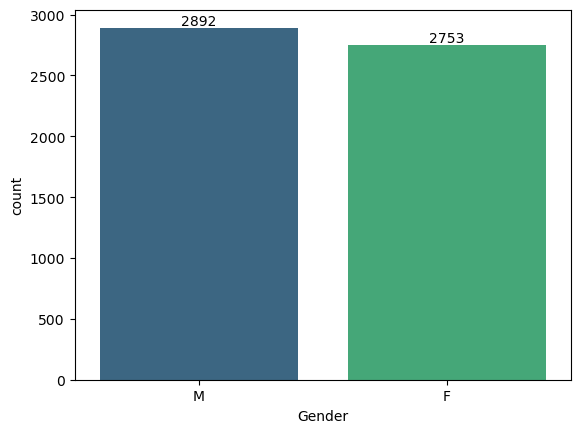

In [19]:
count_plot(cust_df, 'Gender')

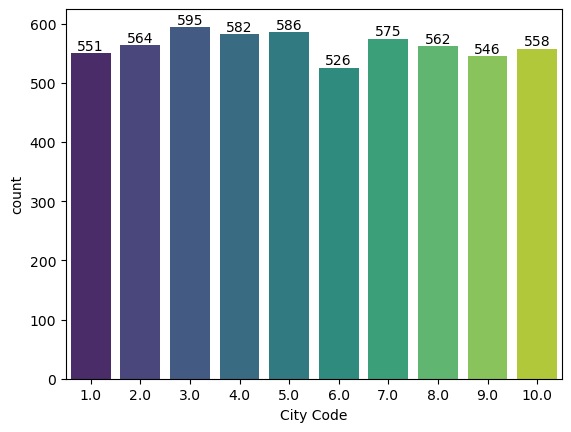

In [20]:
count_plot(cust_df, 'City Code')

<h3 style="color:orange">Transactions data Analysis </h3>

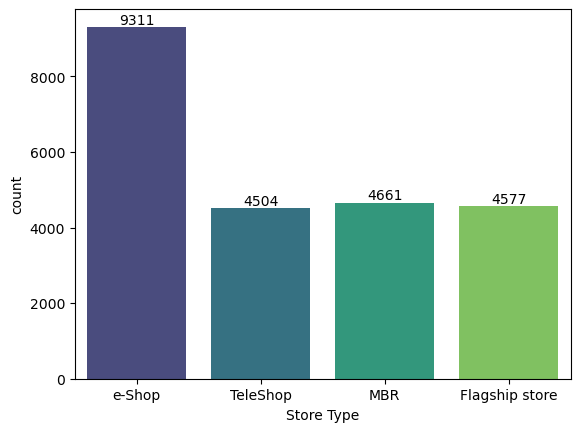

In [21]:
count_plot(tran_df, 'Store Type')

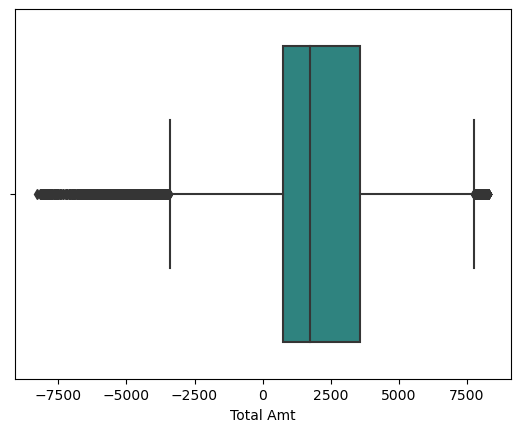

In [22]:
box_plot(tran_df, 'Total Amt')

There has some negative values detected for total amount which is misleading. We will take care of this in the preprocessing part 

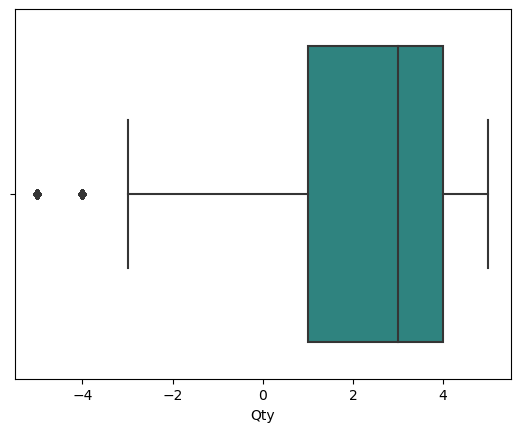

In [23]:
box_plot(tran_df, 'Qty')

Here also negative values found in the Quantity attribute which is misleading

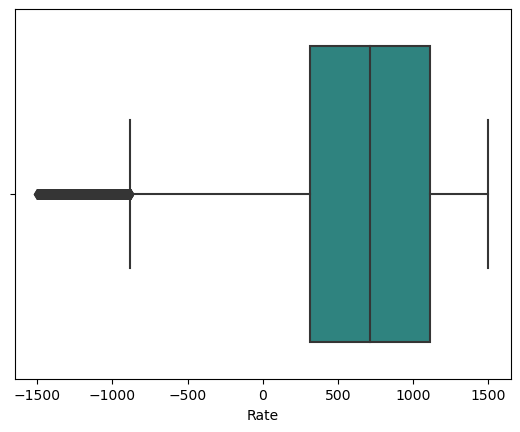

In [24]:
box_plot(tran_df, 'Rate')

same goes for the Amount attribute, negative values in Rate is misleading

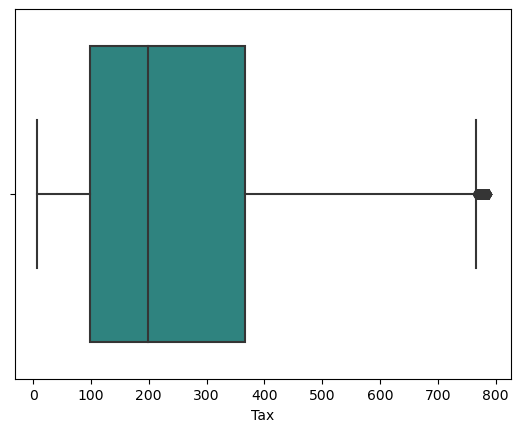

In [25]:
box_plot(tran_df, 'Tax')

<h3 style="color:orange"> Product Analysis <h3>

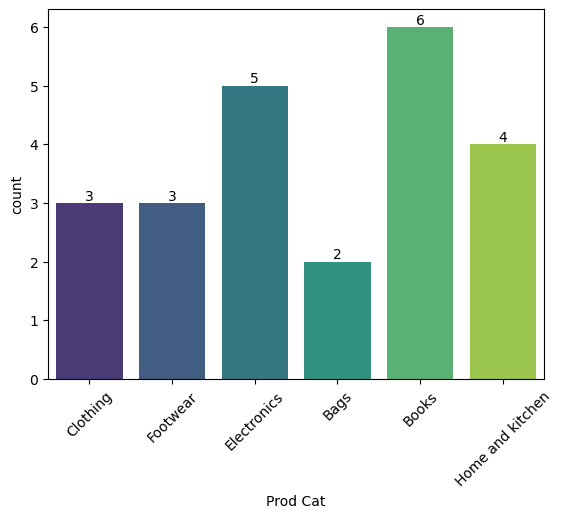

In [26]:
count_plot(prod_df, 'Prod Cat', 45)


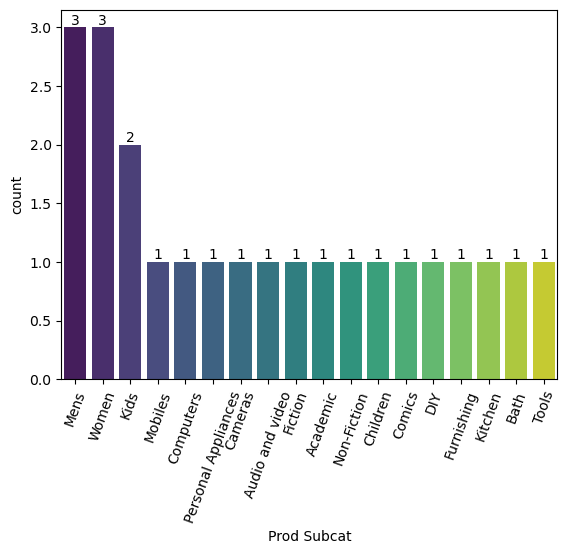

In [27]:
count_plot(prod_df, 'Prod Subcat', 70)

# iii) Bivariate Analysis

# 3) Data Cleaning and Preprocessing 

## i) Transaction Data

In [28]:
#first make a copy, we don't want to ruin our main dataframe
tran_df2 = tran_df.copy()
cust_df2 = cust_df.copy()
prod_df2 = prod_df.copy()

### Preprocessing Steps
1. Remove inappropriate rows (Total amount, Rate, Qty can't be negative).
2. Convert Transaction Date to date time format.
3. Calculate netsales (without Tax)

In [29]:
# Remove inappropriate rows (Negative Qty, Rate and Total Amount all are associated, So considering 1 column will work)
tran_df2 = tran_df2[tran_df2['Total Amt'] > 0] 

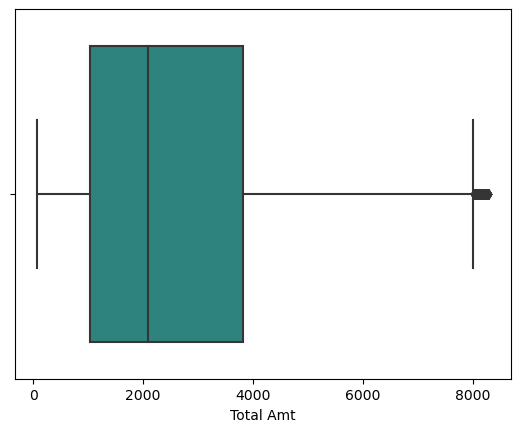

In [30]:
# now check
box_plot(tran_df2, 'Total Amt')

In [31]:
#convert date to datetime format 
tran_df2['Transaction Date'] = pd.to_datetime(tran_df2['Transaction Date'],dayfirst = True) 

In [32]:
#Calculate netsales (without Tax)
tran_df2['Net_Sales'] = tran_df2['Qty'] * tran_df2['Rate'] 

In [33]:
tran_df2.head()

,Transaction ID,Customer ID,Transaction Date,Prod Subcat Code,Prod Cat Code,Qty,Rate,Tax,Total Amt,Store Type,Net_Sales
10,29258453508,270384,2014-02-20,5,3,5,1497,785.925,8270.925,e-Shop,7485
11,25455265351,267750,2014-02-20,12,6,3,1360,428.400,4508.400,e-Shop,4080
12,1571002198,275023,2014-02-20,6,5,4,587,246.540,2594.540,e-Shop,2348
14,36554696014,269345,2014-02-20,3,5,3,1253,394.695,4153.695,e-Shop,3759
15,56814940239,268799,2014-02-20,7,5,5,368,193.200,2033.200,e-Shop,1840


## ii) Product Data

In [34]:
prod_df2

,Prod Cat Code,Prod Cat,Prod Subcat Code,Prod Subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women
5,2,Footwear,4,Kids
6,3,Electronics,4,Mobiles
7,3,Electronics,5,Computers
8,3,Electronics,8,Personal Appliances
9,3,Electronics,9,Cameras


In [35]:
prod_df2.groupby('Prod Cat Code')['Prod Cat'].value_counts()  

Prod Cat Code  Prod Cat        
1              Clothing            3
2              Footwear            3
3              Electronics         5
4              Bags                2
5              Books               6
6              Home and kitchen    4
Name: Prod Cat, dtype: int64

In [36]:
prod_df2.groupby('Prod Subcat Code')['Prod Subcat'].value_counts() 

Prod Subcat Code  Prod Subcat        
1                 Mens                   2
                  Women                  1
2                 Furnishing             1
3                 Comics                 1
                  Kids                   1
                  Women                  1
4                 Kids                   1
                  Mens                   1
                  Mobiles                1
                  Women                  1
5                 Computers              1
6                 DIY                    1
7                 Fiction                1
8                 Personal Appliances    1
9                 Cameras                1
10                Audio and video        1
                  Kitchen                1
                  Non-Fiction            1
11                Bath                   1
                  Children               1
12                Academic               1
                  Tools                  1
Name: Prod Subca

from the product subcategory we are unable to find any proper indication of any specific product. So, merging category and subcategory will help identifying the specific product

### Preprocessing Steps
We will merge the category and subcategory for the simplicity in model building
1. Merge Prod_Cat_Code and Prod_subcat_code to 'Product Code'
2. Merge Prod_Cat and Prod_Subcat to 'Product Info'

In [37]:
#merge 'Prod Cat' with 'Prod Subcat' 
prod_df2['Product Info'] = prod_df2['Prod Cat'].astype(str) + '_'+ prod_df2['Prod Subcat'].astype(str)

In [38]:
#merge 'Prod Cat Code' and 'Prod Subcat Code'
prod_df2['Product Code'] = prod_df2['Prod Cat Code'].astype(str) + '_'+ prod_df2['Prod Subcat Code'].astype(str)  

In [39]:
prod_df2.head()

,Prod Cat Code,Prod Cat,Prod Subcat Code,Prod Subcat,Product Info,Product Code
0,1,Clothing,4,Mens,Clothing_Mens,1_4
1,1,Clothing,1,Women,Clothing_Women,1_1
2,1,Clothing,3,Kids,Clothing_Kids,1_3
3,2,Footwear,1,Mens,Footwear_Mens,2_1
4,2,Footwear,3,Women,Footwear_Women,2_3


## Download the preprocessed dataset 

In [40]:
tran_df2.to_csv('../archive/processed_transactions_data.csv', index = False)

In [41]:
prod_df2.to_csv('../archive/processed_product_data.csv', index = False)

In [42]:
cust_df2.to_csv('../archive/processed_customer_data.csv', index = False)